# Evaluation of the RandomForest model

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from scivision.io import load_pretrained_model, load_dataset

## Load datasets

### load holdout images

In [5]:
cat = load_dataset('https://github.com/alan-turing-institute/plankton-dsg-challenge')

ds_all = cat.plankton_multiple().to_dask()
labels_holdout = cat.labels_holdout().read()

labels_holdout_dedup = xr.Dataset.from_dataframe(
    labels_holdout
    .drop_duplicates(subset=["filename"])
    .set_index("filename")
    .sort_index()
)

ds_holdout_labelled = (
    ds_all
    .swap_dims({"concat_dim": "filename"})
    .merge(labels_holdout_dedup, join="inner")
    .swap_dims({"filename": "concat_dim"})
)

In [6]:
ds_holdout_labelled = ds_holdout_labelled.assign(
    image_width = ds_holdout_labelled['EXIF Image ImageWidth'].to_pandas().apply(lambda x: x.values[0]),
    image_length = ds_holdout_labelled['EXIF Image ImageLength'].to_pandas().apply(lambda x: x.values[0])
)

## Load pretrained model

In [18]:
# run if changes are made in https://github.com/acocac/scivision-plankton-models then restart the kernel
#!pip -q uninstall -y scivision_plankton_models 

In [3]:
# Load model
scivision_yml = 'https://github.com/acocac/scivision-plankton-models/.scivision-config-randomforest_label3.yaml'
model = load_pretrained_model(scivision_yml, allow_install=True)

In [4]:
model

scivision.PretrainedModel( 
  module='scivision_plankton_models', 
  model='randomforest_label3', 
  source='https://github.com/acocac/scivision-plankton-models' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

## Dataset and Dataloader

In [7]:
from scivision_plankton_models import PlanktonDataset
from torch.utils.data import DataLoader
import tqdm
import torch
import matplotlib.pyplot as plt

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [14]:
dataset = PlanktonDataset(ds_holdout_labelled, model='randomforest',output_path='/scratch/morphocut')

batch_size=24

num_iterations = max(1, len(dataset) // batch_size)
print(num_iterations)

In [15]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

## Predict and visualise

In [38]:
for i, inputs in tqdm.tqdm(enumerate(dataloader)):
    inputs = inputs.to(device)
    preds = model.predict(inputs)
    break

0it [00:01, ?it/s]


In [42]:
im_idx = 6
im_target = ds_holdout_labelled.sel(concat_dim=ds_holdout_labelled.concat_dim[im_idx])
image = im_target['raster'].values
label_gt = im_target['label3'].values
imw = im_target.image_width.values
iml = im_target.image_length.values

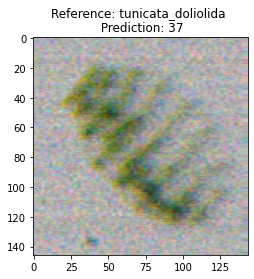

In [43]:
plt.figure()
plt.imshow(image[0:iml, 0:imw, :])
plt.title("Reference: {} \n Prediction: {}".format(label_gt, preds[im_idx]))
plt.show()